# Forest Plot

> Explanation of how to use forest_plot for contrast objects e.g delta-delta and mini-meta.

- order: 7

In DABEST version 2025.02.28, we introduce a new function to plot separately calculated effect sizes in the same axes to allow direct visual comparisons. 

Currently you can make a forest plot for delta-delta and mini-meta effect sizes. In addition, for delta-delta experiments, you can also plot the effect sizes of the original comparisons alongside the delta-delta measurement.

## Load libraries

In [ ]:
import numpy as np
import pandas as pd
import dabest
from dabest.forest_plot import forest_plot
import matplotlib.pyplot as plt
import dabest 
print("We're using DABEST v{}".format(dabest.__version__))

Pre-compiling numba functions for DABEST...


Compiling numba functions: 100%|██████████| 11/11 [00:03<00:00,  3.66it/s]


Numba compilation complete!
We're using DABEST v2024.03.30


## Delta-delta effects

First please revisit the notebook '[Delta-delta Tutorial](06-delta_delta.html)' for how to generate a delta-delta effect size. We will generate three of them plot them into the same axes. Here we test the efficacy of 3 drugs named ``Drug1``, ``Drug2`` , and ``Drug3`` on a disease-causing mutation ```M``` based on disease metric ```Tumor Size```.  We want to know how the three drugs fare in ameliorating the phenotype metric ```Tumor Size```. 

|       | Wildtype | Mutant   |
|-------|---------|----------|
| Drug1  | X<sub>D<sub>1, W</sub> | X<sub>D<sub>1, M</sub> |
| Placebo | X<sub>P<sub>1, W</sub> | X<sub>P<sub>1, M</sub> |

|       | Wildtype | Mutant   |
|-------|---------|----------|
| Drug2  | X<sub>D<sub>2, W</sub> | X<sub>D<sub>2, M</sub> |
| Placebo | X<sub>P<sub>2, W</sub> | X<sub>P<sub>2, M</sub> |

|       | Wildtype | Mutant   |
|-------|---------|----------|
| Drug3  | X<sub>D<sub>3, W</sub> | X<sub>D<sub>3, M</sub> |
| Placebo | X<sub>P<sub>3, W</sub> | X<sub>P<sub>3, M</sub> |

In each scenario, there are two ``Treatment`` conditions, ``Placebo`` (control group) and ``Drug`` (test group). There are two ``Genotype``\'s: ``W`` (wild type population) and ``M`` (mutant population). Additionally, each experiment was conducted twice (``Rep1`` and ``Rep2``). We will perform several analyses to visualise these differences in a simulated dataset. We will simulate three separte datasets below. 

### Creating a demo dataset

In [ ]:
from scipy.stats import norm
def create_delta_dataset(N=20, 
                        seed=9999, 
                        second_quarter_adjustment=3, 
                        third_quarter_adjustment=-0.1):
    np.random.seed(seed)  # Set the seed for reproducibility

    # Create samples
    y = norm.rvs(loc=3, scale=0.4, size=N*4)
    y[N:2*N] += second_quarter_adjustment
    y[2*N:3*N] += third_quarter_adjustment

    # Treatment, Rep, Genotype, and ID columns
    treatment = np.repeat(['Placebo', 'Drug'], N*2).tolist()
    rep = ['Rep1', 'Rep2'] * (N*2)
    genotype = np.repeat(['W', 'M', 'W', 'M'], N).tolist()
    id_col = list(range(0, N*2)) * 2

    # Combine all columns into a DataFrame
    df = pd.DataFrame({
        'ID': id_col,
        'Rep': rep,
        'Genotype': genotype,
        'Treatment': treatment,
        'Tumor Size': y
    })

    return df

# Generate the first dataset with a different seed and adjustments
df_delta2_drug1 = create_delta_dataset(seed=9999, second_quarter_adjustment=1, third_quarter_adjustment=-0.5)

# Generate the second dataset with a different seed and adjustments
df_delta2_drug2 = create_delta_dataset(seed=9999, second_quarter_adjustment=0.1, third_quarter_adjustment=-1)

# Generate the third dataset with the same seed as the first but different adjustments
df_delta2_drug3 = create_delta_dataset(seed=9999, second_quarter_adjustment=3, third_quarter_adjustment=-0.1)

### Loading data

In [ ]:
unpaired_delta_01 = dabest.load(data = df_delta2_drug1, 
                                x = ["Genotype", "Genotype"], 
                                y = "Tumor Size", delta2 = True, 
                                experiment = "Treatment")
unpaired_delta_02 = dabest.load(data = df_delta2_drug2, 
                                x = ["Genotype", "Genotype"], 
                                y = "Tumor Size", delta2 = True, 
                                experiment = "Treatment")
unpaired_delta_03 = dabest.load(data = df_delta2_drug3, 
                                x = ["Genotype", "Genotype"], 
                                y = "Tumor Size", 
                                delta2 = True, 
                                experiment = "Treatment")
contrasts = [unpaired_delta_01, unpaired_delta_02, unpaired_delta_03]

### Generate delta-delta plots for each datasets 

To create a delta-delta plot, you simply need to set ``delta2=True`` in the 
``dabest.load()`` function and ``mean_diff.plot()``

In this case,``x`` needs to be declared as a list consisting of 2 elements, unlike most cases where it is a single element. 
The first element in ``x`` will represent the variable plotted along the horizontal axis, and the second one will determine the 
color of dots for scattered plots or the color of lines for slope graphs. We use the ``experiment`` input to specify the grouping of the data.

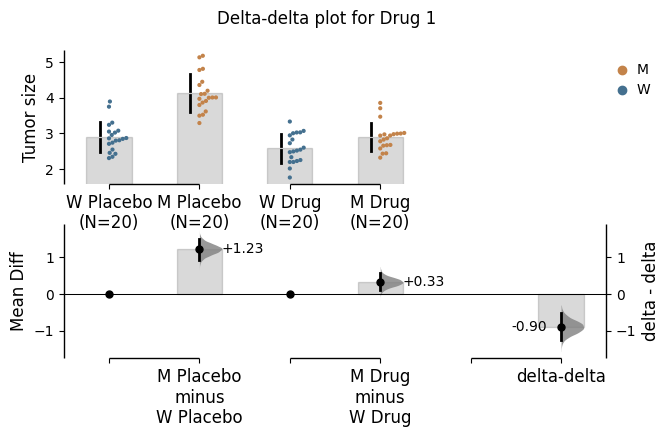

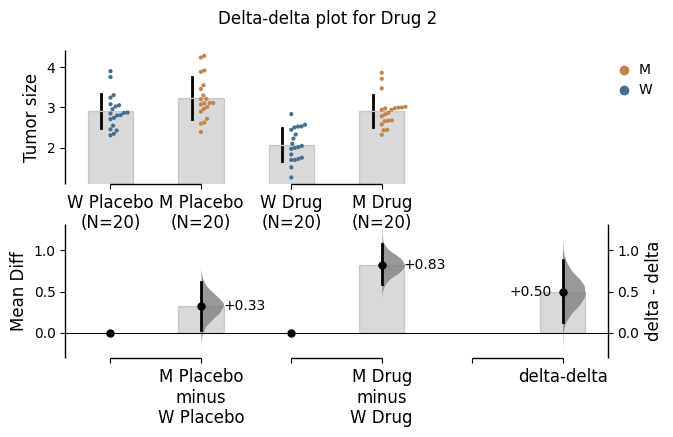

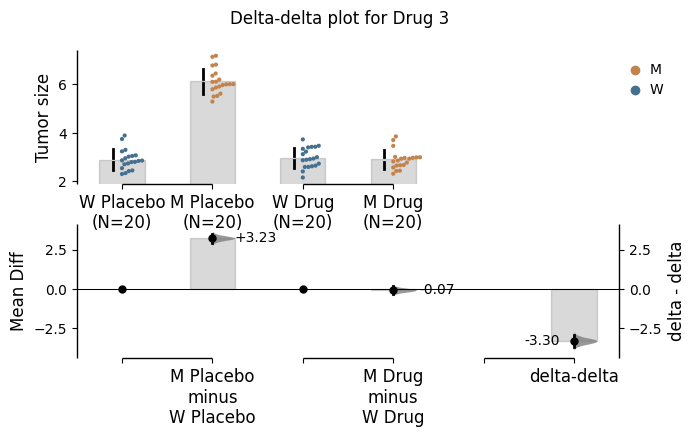

In [ ]:

f1 = unpaired_delta_01.mean_diff.plot(
    contrast_label='Mean Diff',
    fig_size = (7, 4),
    raw_marker_size = 1,
    es_marker_size = 5,
);
f1.suptitle('Delta-delta plot for Drug 1');


f2 = unpaired_delta_02.mean_diff.plot(                  
            contrast_label='Mean Diff',
            fig_size = (7, 4),
            raw_marker_size = 1,
            es_marker_size = 5,
);
f2.suptitle('Delta-delta plot for Drug 2');


f3 = unpaired_delta_03.mean_diff.plot(                  
                    contrast_label='Mean Diff',
                    fig_size = (7, 4),
                    raw_marker_size = 1,
                    es_marker_size = 5,
);
f3.suptitle('Delta-delta plot for Drug 3');


### Generate a forest plot

This will allow for comparisons of different ``Drug`` effects.

Key Parameters:

- ``data``: A list of dabest objects 

- ``labels``: A list of labels for the dabest objects. E.g., ``['Drug1', 'Drug2', 'Drug3']``

- ``effect_size``: Select the effect size metric from ``"mean_diff", "median_diff", "cliffs_delta", "cohens_d", "hedges_g", or "delta_g"``. The default is ``"mean_diff"``. Not all effect sizes are available for all situations.

- ``horizontal``: A boolean input (``True``/ ``False``) to adjust the plot orientation. The default is vertical orientation (``False``) 

- ``ax``: Optional: To specify an existing matplotlib axes (otherwise a standalone figure will be created) 

See the [Controlling Aesthetics](#Controlling-Aesthetics) section for more information on how to alter the aesthetics of the plots.


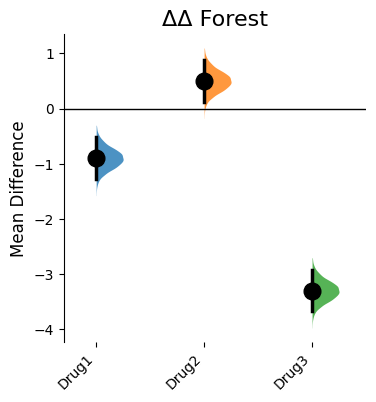

In [ ]:
f_forest_delta2 = forest_plot(
                        data = contrasts, 
                        labels = ['Drug1', 'Drug2', 'Drug3']
);

### Generate a forest plot with delta effect sizes alongside the delta-delta effect sizes

If you want to plot the original effect sizes alongside the delta-delta effect sizes, you can do so by utilising the `idx` parameter. 

This parameter takes a tuple/list of indices of the original effect sizes you want to plot. This `idx` parameter is only available for delta-delta dabest objetcs. 

For example, if you want to plot only the first effect size and the delta-delta effect size for each of the three dabest object supplied, you can do so by setting `idx=[[0, 2],[0, 2],[0, 2]]`.

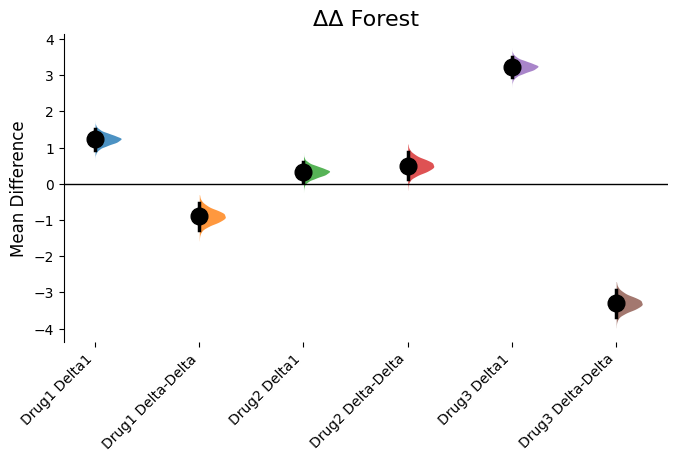

In [ ]:
f_forest_delta2 = forest_plot(
                        data = contrasts, 
                        labels = ['Drug1 Delta1', 'Drug1 Delta-Delta', 'Drug2 Delta1', 'Drug2 Delta-Delta', 'Drug3 Delta1', 'Drug3 Delta-Delta'],
                        idx=[[0, 2], [0, 2], [0, 2]]
);

## Mini-meta effects:
Next we will generate a similar forest plot for mini-meta effect sizes. Please revisit the notebook '[Mini-meta Tutorial](05-mini_meta.html)' on how to generate a mini-meta effect size. We will generate three mini-meta effect sizes for three separate mini-meta analyses:

### Creating a demo dataset

In [ ]:
def create_mini_meta_dataset(N=20, seed=9999, control_locs=[3, 3.5, 3.25], control_scales=[0.4, 0.75, 0.4], 
                             test_locs=[3.5, 2.5, 3], test_scales=[0.5, 0.6, 0.75]):
    np.random.seed(seed)  # Set the seed for reproducibility

    # Create samples for controls and tests
    controls_tests = []
    for loc, scale in zip(control_locs + test_locs, control_scales + test_scales):
        controls_tests.append(norm.rvs(loc=loc, scale=scale, size=N))

    # Add a `Gender` column for coloring the data
    gender = ['Female'] * (N // 2) + ['Male'] * (N // 2)

    # Add an `ID` column for paired data plotting
    id_col = list(range(1, N + 1))

    # Combine samples and gender into a DataFrame
    df_columns = {f'Control {i+1}': controls_tests[i] for i in range(len(control_locs))}
    df_columns.update({f'Test {i+1}': controls_tests[i + len(control_locs)] for i in range(len(test_locs))})
    df_columns['Gender'] = gender
    df_columns['ID'] = id_col

    df = pd.DataFrame(df_columns)

    return df

# Customizable dataset creation with different arguments
df_mini_meta01 = create_mini_meta_dataset(seed=9999, 
                                          control_locs=[3, 3.5, 3.25], 
                                          control_scales=[0.4, 0.75, 0.4], 
                                          test_locs=[3.5, 2.5, 3], 
                                          test_scales=[0.5, 0.6, 0.75])

df_mini_meta02 = create_mini_meta_dataset(seed=9999, 
                                          control_locs=[4, 2, 3.25], 
                                          control_scales=[0.3, 0.75, 0.45], 
                                          test_locs=[2, 1.5, 2.75], 
                                          test_scales=[0.5, 0.6, 0.4])

df_mini_meta03 = create_mini_meta_dataset(seed=9999, 
                                          control_locs=[6, 5.5, 4.25], 
                                          control_scales=[0.4, 0.75, 0.45], 
                                          test_locs=[4.5, 3.5, 3], 
                                          test_scales=[0.5, 0.6, 0.9])

### Loading data

In [ ]:
contrast_mini_meta01 = dabest.load(data = df_mini_meta01,
                                   idx=(("Control 1", "Test 1"), ("Control 2", "Test 2"), ("Control 3", "Test 3")), 
                                   mini_meta=True)
contrast_mini_meta02 = dabest.load(data = df_mini_meta02,
                                    idx=(("Control 1", "Test 1"), ("Control 2", "Test 2"), ("Control 3", "Test 3")), 
                                    mini_meta=True)
contrast_mini_meta03 = dabest.load(data = df_mini_meta03,
                                   idx=(("Control 1", "Test 1"), ("Control 2", "Test 2"), ("Control 3", "Test 3")),
                                    mini_meta=True)
contrasts_mini_meta = [contrast_mini_meta01, contrast_mini_meta02, contrast_mini_meta03]    
                              

### Generate a forest plot

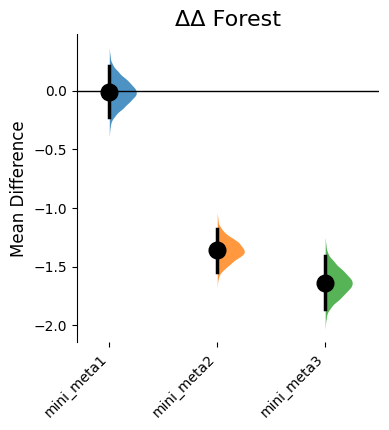

In [ ]:
f_forest_minimeta = forest_plot(
                        data = contrasts_mini_meta, 
                        labels=['mini_meta1', 'mini_meta2', 'mini_meta3']
);

## Controlling Aesthetics

The main aesthetic parameters for the forest_plot function are:

- `fig_size`: The size of the figure

- ``horizontal``: A boolean input (``True``/ ``False``) to adjust the plot orientation. The default is vertical orientation (``False``) 

- `custom_palette`: A list or dictionary of colors, one for each contrast object. E.g., `['gray', 'blue', 'green']` or `{'Drug1':'gray', 'Drug2':'blue', 'Drug3':'green'}` or a set of colors from seaborn color palettes.

- `marker_size`: The size of the markers for the effect sizes. The default is 12.

- ``halfviolin_alpha``: Transparency level for violin plots. The default is 0.8.

- ``halfviolin_desat``: Saturation level for violin plots. The default is 1.

- `labels_rotation`: Rotation angle for contrast labels. The default is 45.

- `labels_fontsize`: Font size for contrast labels. The default is 10.

- ``title``: The plot title. The default is ``"ΔΔ Forest"``

- ``title_fontsize``: Font size for the plot title. The default is 16.

- ``ylabel``: The axis label of dependent variable (Y-axis for vertical layout, X-axis for horizontal layout). The default will be given via the effect size selected. (eg., ``"Mean Difference"`` for ``"mean_diff"``)

- ``ylabel_fontsize``: Font size for the axis label (Y-axis for vertical layout, X-axis for horizontal layout). The default is 12.

- ``ylim``: Limits for the dependent variable (Y-axis for vertical layout, X-axis for horizontal layout). The default is None.

- ``yticks``: Custom ticks (Y-axis for vertical layout, X-axis for horizontal layout) for the plot. The default is None.

- ``yticklabels``: Custom tick labels (Y-axis for vertical layout, X-axis for horizontal layout) for the plot. The default is None.

- ``remove_spines``: If True, removes plot spines (except the relevant dependent variable spine). The default is True.

- `violins_kwargs`: A dictionary of keyword arguments for the violin plots. 
  
        The default violin kwargs = {"widths": 0.5, "showextrema": False, "showmedians": False, "vert": not horizontal}

- `zeroline_kwargs`: A dictionary of keyword arguments for the zero line. The default is None.
  
        The default zeroline kwargs = {"linewidth": 1, "color": "black"}

- `es_marker_kwargs`: A dictionary of keyword arguments for the effect size markers. The default is None.
  
        The default es marker kwargs = {'marker': 'o', 'markersize': 12, 'color': 'black', 'alpha': 1, 'zorder': 2}

- `es_errorbar_kwargs`: A dictionary of keyword arguments for the effect size error bars. The default is None.
  
        The default es errorbar kwargs = {'color': 'black', 'lw': 2.5, 'linestyle': '-', 'alpha': 1, 'zorder': 1}

### Changing layout with `horizontal`
Forest plot assumes a vertical layout by default, but you can change it to a horizontal layout by setting ```horizontal``` to be ```True```:

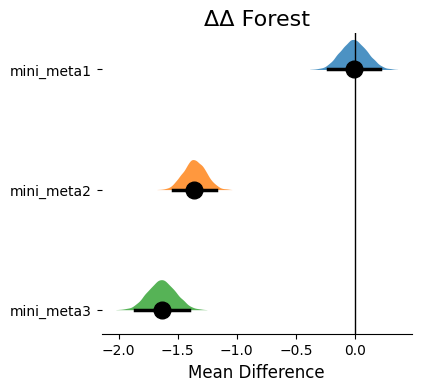

In [ ]:
f_forest_minimeta = forest_plot(
                        data = contrasts_mini_meta, 
                        labels=['mini_meta1', 'mini_meta2', 'mini_meta3'],
                        horizontal=True,)

### Using a custom palette 
You can color the half-violins with ```custom_palette```:

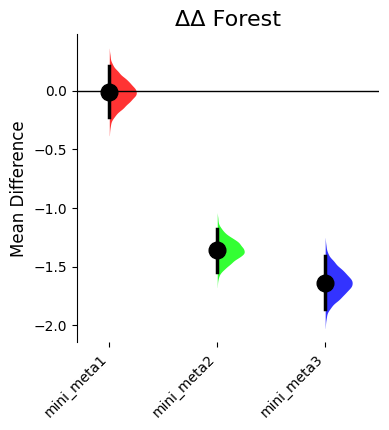

In [ ]:
f_forest_minimeta = forest_plot(
                        data = contrasts_mini_meta, 
                        labels=['mini_meta1', 'mini_meta2', 'mini_meta3'],
                        custom_palette=['#FF0000', '#00FF00', '#0000FF'],)

### Plotting other effect sizes 
Forest plots can be drawn for effect sizes other than mean_difference, such as ```hedges_g```, by setting ```effect_size```:

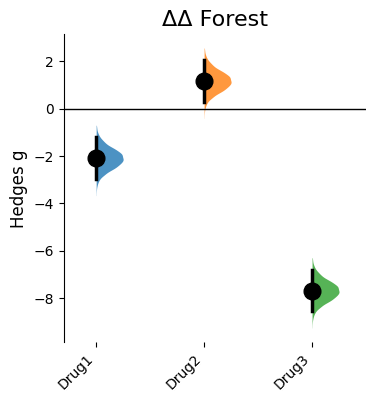

In [ ]:
f_forest_hedgesg = forest_plot(
                            data = contrasts, 
                            labels =['Drug1', 'Drug2', 'Drug3'], 
                            effect_size='hedges_g',
);

### Embedding forest plots into an existing Axes 

You can plot a forest plot into an existing Axes as a subplot by using the with the ``ax`` parameter. 

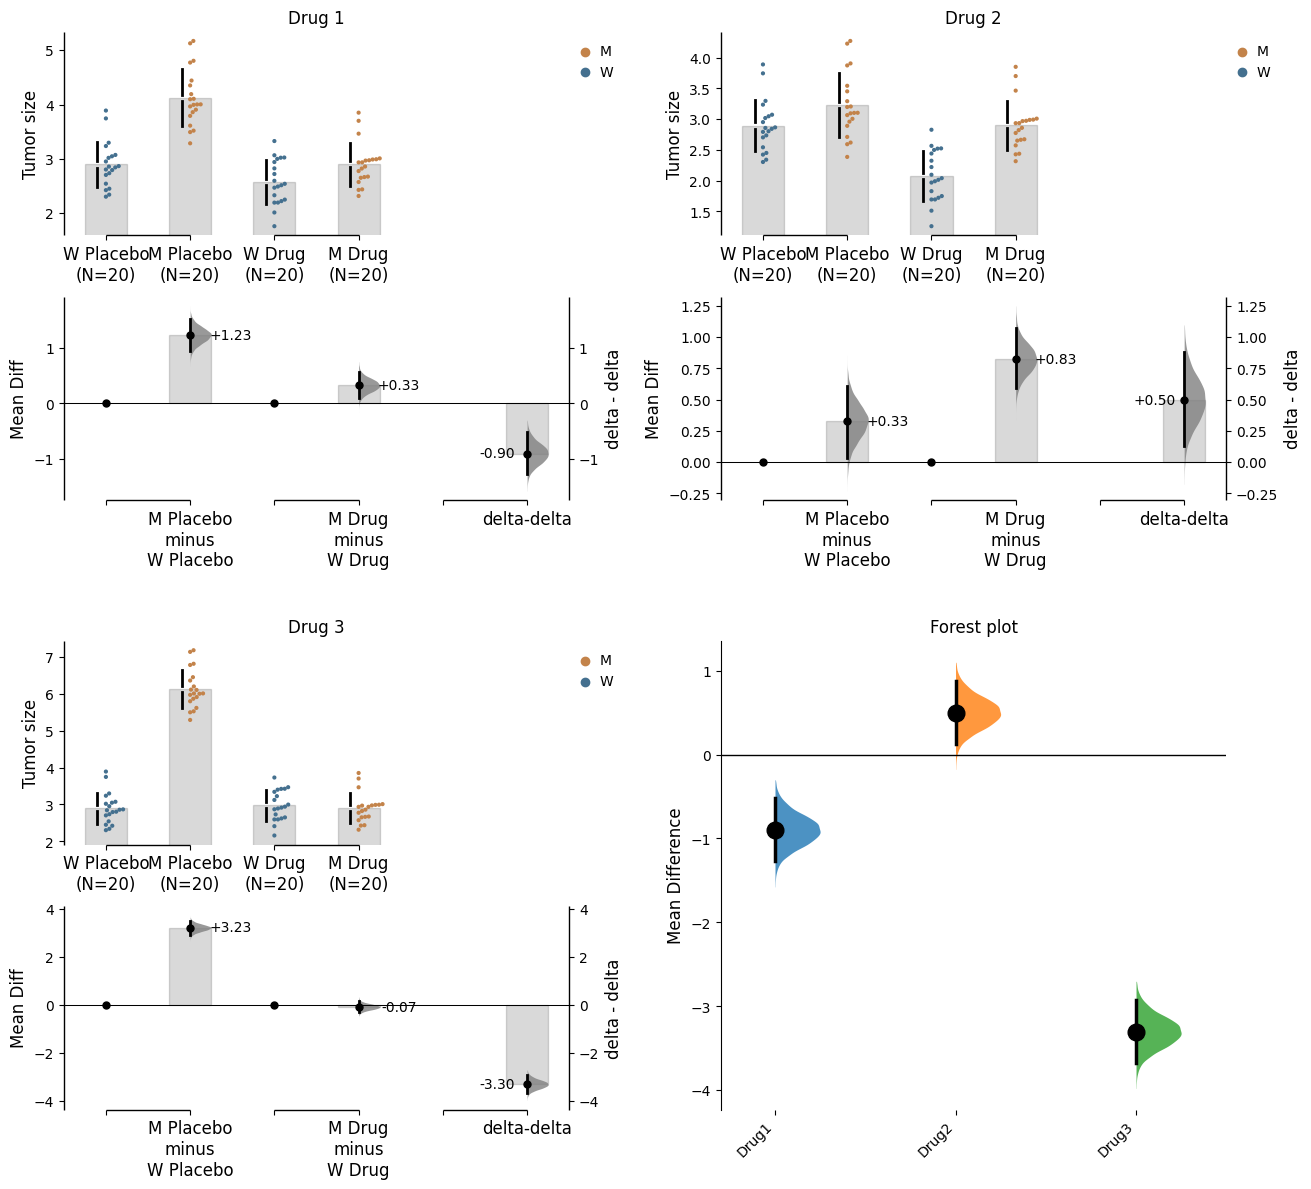

In [ ]:
f_forest_drug_profiles, axes  = plt.subplots(2, 2, figsize=[15, 14])
f_forest_drug_profiles.subplots_adjust(hspace=0.3, wspace=0.3)

for ax, contrast in zip(axes.flatten(), [unpaired_delta_01, unpaired_delta_02, unpaired_delta_03]):
    contrast.mean_diff.plot(                  
                    contrast_label='Mean Diff',
                    raw_marker_size = 1,
                    es_marker_size = 5,
                    color_col='Genotype',
                    ax = ax
    )

forest_plot(
    data = contrasts, 
    labels = ['Drug1', 'Drug2', 'Drug3'], 
    ax = axes[1,1], 
    )

for ax, title in zip(axes.flatten(), ['Drug 1', 'Drug 2', 'Drug 3', 'Forest plot']):
    ax.set_title(title, fontsize = 12)